# Разработка A/B-тестирования и анализ результатов

## Описание данных

Предосталенны три таблицы:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

### Работа с историческими данными (EDA)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from math import ceil
from scipy import stats as st
import statsmodels.api as sm

sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [2]:
uni_sessions = sessions_history.groupby('user_id')['session_id'].nunique().sort_values(ascending = False).reset_index()
sessions_history[sessions_history['user_id'] == uni_sessions.iloc[0]['user_id']]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

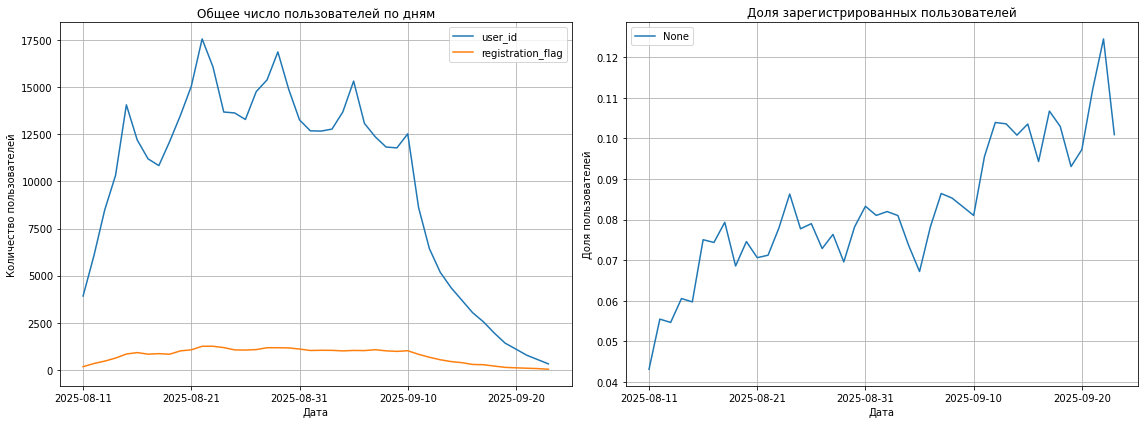

In [3]:
users = sessions_history.groupby('session_date').agg({'user_id': 'nunique', 'registration_flag': 'sum'})

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

users.plot(kind='line',
           grid=True,
           legend=True,
           title='Общее число пользователей по дням',
           xlabel='Дата',
           ylabel='Количество пользователей',
           ax=axs[0])

users_rat = users['registration_flag'] / users['user_id']
users_rat.plot(kind='line',
               grid=True,
               legend=True,
               title='Доля зарегистрированных пользователей',
               xlabel='Дата',
               ylabel='Доля пользователей',
               ax=axs[1])

plt.tight_layout()
plt.show()

#### Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

<AxesSubplot:title={'center':'Соотношение просмотренных страниц по сессиям'}, xlabel='Количество страниц', ylabel='Количество сессий'>

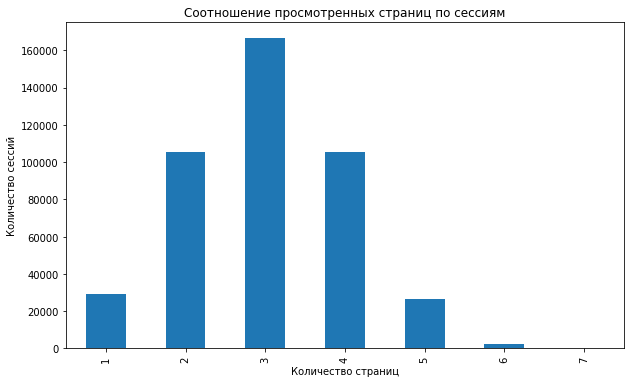

In [4]:
list_session = sessions_history.groupby('page_counter')['session_id'].count()

list_session.plot(kind = 'bar',
                  figsize=(10, 6),
                  title = 'Соотношение просмотренных страниц по сессиям',
                  xlabel = 'Количество страниц',
                  ylabel = 'Количество сессий')

#### Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

<AxesSubplot:title={'center':'Доля успешных сессий'}, xlabel='session_date'>

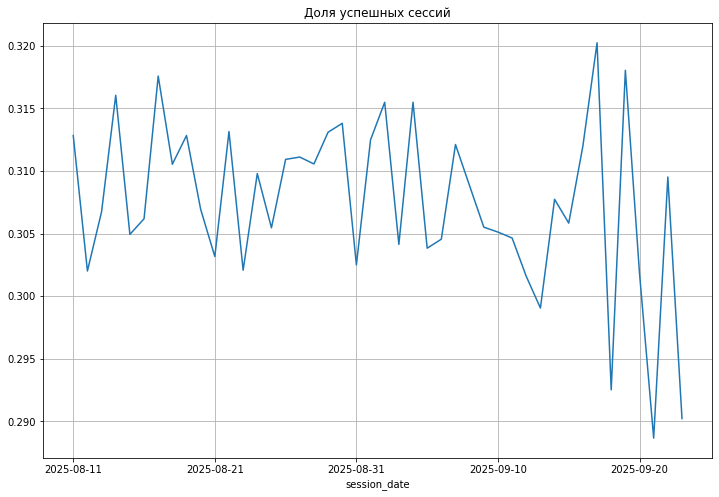

In [5]:
def category_session (i):
    if i >= 4:
        return 1
    else:
        return 0
    
sessions_history['good_session'] = sessions_history['page_counter'].apply(category_session)

rate_good_sessions = sessions_history.groupby('session_date').agg({'session_id': 'count', 'good_session': 'sum'})
rate_good_sessions = rate_good_sessions['good_session'] / rate_good_sessions['session_id']

rate_good_sessions.plot(kind = 'line',
                  figsize=(12, 8),
                  grid=True,
                  title = 'Доля успешных сессий')

### Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### Расчёт размера выборки

In [6]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### Расчёт длительности A/B-теста

Рассчитаем длительность теста используя данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. 

In [7]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = int(users['user_id'].mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(int(sample_size*2) / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровне трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровне трафика в 9907 пользователей в день составит 4 дней


### Мониторинг А/В-теста

0    1477
1    1466
Name: user_id, dtype: int64

Процентная разница в количестве пользователей в группах A и B: 0    0.74
dtype: float64


<AxesSubplot:title={'center':'Пользователи групп А/В'}>

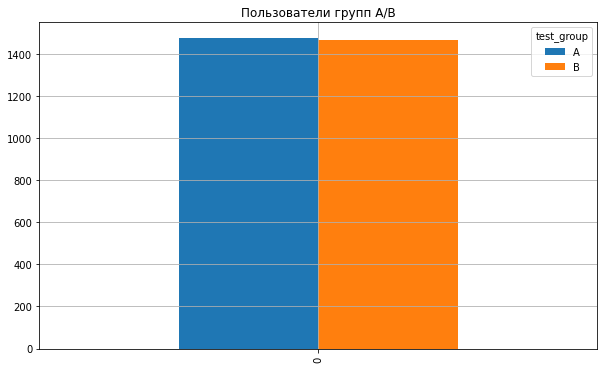

In [8]:
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

group_users_d = sessions_test_part.groupby(['session_date', 'test_group'])['user_id'].nunique().reset_index()

pivot_users = group_users_d.pivot(index='session_date', columns='test_group', values='user_id').reset_index()

persent_diff =round(100 * (pivot_users['A'] - pivot_users['B']) / pivot_users['A'], 2)

print(group_users_d['user_id'])
print()
print(f"Процентная разница в количестве пользователей в группах A и B: {persent_diff}") 
#Прошу подскажите как красиво оформить % разницу без индекса и подписи dtype (reset_index не помог:С)

pivot_users.plot(kind = 'bar', figsize=(10, 6), grid=True, title = 'Пользователи групп А/В',legend=True)

#### Проверка пересечений пользователей

In [9]:
a_group = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']
b_group = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']

intersection = list(set(a_group) & set(b_group))
print(intersection) 

[]


In [10]:
# Как то так?
uni_group = sessions_test_part.groupby('user_id')['test_group'].nunique().sort_values(ascending = False)
uni_group

user_id
00079359B9D3C6F7    1
ADC2E1E1158CFBB2    1
ADCEEDAD20F4782F    1
ADDCDDC883993FA6    1
AE072C4F9B473BCD    1
                   ..
54C3FA4C32B6ABBA    1
54F28A45A5E77DB8    1
54FF42B690A9B2E5    1
55529D5E3198D24D    1
FFFCDE7746148710    1
Name: test_group, Length: 2943, dtype: int64

#### Равномерность разделения пользователей по устройствам
Убедимся что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

/tmp/ipykernel_560/190469305.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  device_group_a['rate_device'] = round(device_group_a['user_id'] / device_group_a['user_id'].sum(), 2)
/tmp/ipykernel_560/190469305.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  device_group_b['rate_device'] = round(device_group_b['user_id'] / device_group_b['user_id'].sum(), 2)


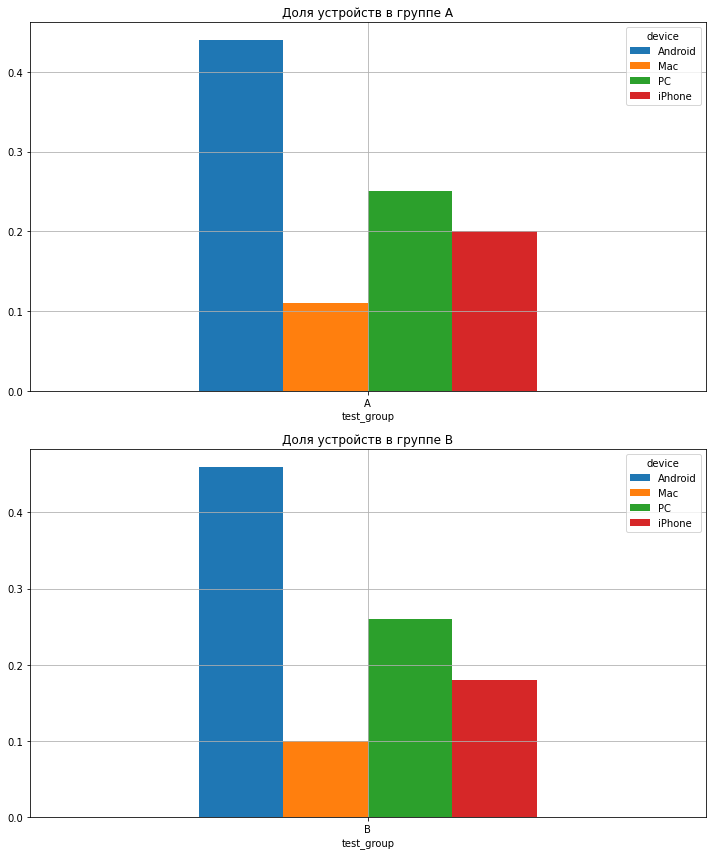

In [11]:
device_group = sessions_test_part.groupby(['test_group', 'device'])['user_id'].nunique().reset_index()

device_group_a = device_group[device_group['test_group'] == 'A']
device_group_b = device_group[device_group['test_group'] == 'B']

device_group_a['rate_device'] = round(device_group_a['user_id'] / device_group_a['user_id'].sum(), 2)
device_group_b['rate_device'] = round(device_group_b['user_id'] / device_group_b['user_id'].sum(), 2)

pivot_device_a = device_group_a.pivot(index='test_group', columns='device', values='rate_device').reset_index()
pivot_device_b = device_group_b.pivot(index='test_group', columns='device', values='rate_device').reset_index()


fig, axs = plt.subplots(2, 1, figsize=(10, 12))

pivot_device_a.plot(kind = 'bar',
                    grid=True, 
                    legend=True, 
                    x='test_group',                     
                    rot=0,
                    ax=axs[0],
                    title='Доля устройств в группе А')

pivot_device_b.plot(kind = 'bar',
                    grid=True, 
                    legend=True, 
                    x='test_group', 
                    rot=0,
                    ax=axs[1],
                    title='Доля устройств в группе B')
# Очень хотел подписать значения внутри столбцов и отсортировать их по убыванию, не получилось сделать это без ошибок. Подскажите как это сделать?
plt.tight_layout()
plt.show()

#### Равномерность распределения пользователей по регионам
Убедимся, что пользователи равномерно распределены по регионам.

/tmp/ipykernel_560/295266176.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_group_a['rate_region'] = round(region_group_a['user_id'] / region_group_a['user_id'].sum(), 2)
/tmp/ipykernel_560/295266176.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_group_b['rate_region'] = round(region_group_b['user_id'] / region_group_b['user_id'].sum(), 2)


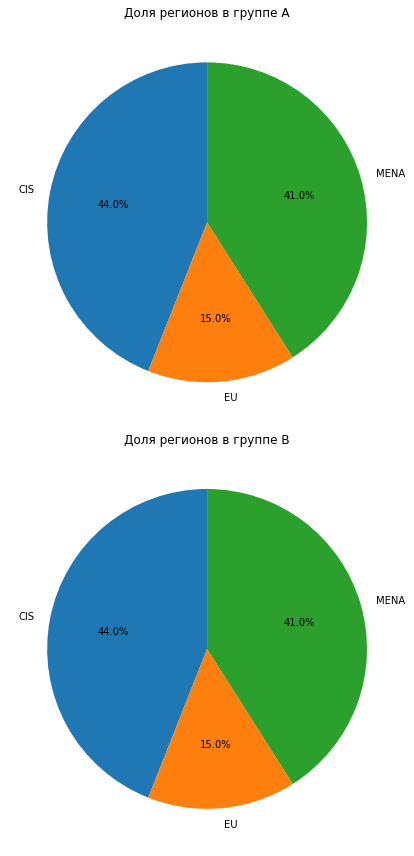

In [12]:
region_group = sessions_test_part.groupby(['test_group', 'region'])['user_id'].nunique().reset_index()

region_group_a = region_group[region_group['test_group'] == 'A']
region_group_b = region_group[region_group['test_group'] == 'B']

region_group_a['rate_region'] = round(region_group_a['user_id'] / region_group_a['user_id'].sum(), 2)
region_group_b['rate_region'] = round(region_group_b['user_id'] / region_group_b['user_id'].sum(), 2)

pivot_region_a = region_group_a.pivot(index='test_group', columns='region', values='rate_region').reset_index()
pivot_region_b = region_group_a.pivot(index='test_group', columns='region', values='rate_region').reset_index()


fig, axs = plt.subplots(2, 1, figsize=(10, 12))

axs[0].pie(region_group_a['rate_region'], 
            labels=region_group_a['region'], 
            autopct='%1.1f%%', 
            startangle=90)
axs[0].set_title('Доля регионов в группе A')

# Построение круговой диаграммы для группы B
axs[1].pie(region_group_b['rate_region'], 
            labels=region_group_b['region'], 
            autopct='%1.1f%%', 
            startangle=90)
axs[1].set_title('Доля регионов в группе B')

plt.tight_layout()
plt.show()

Выводы по итогам анализа:
- Разница в количестве пользователей в группах 11 человек в процентном соотношении это составляет 0.74%
- По результатам проверки группы не содержат одинаковых пользователей → группы независимы.
- Распределение групп по девайсам неравномерное, преобладает платформа Android, наименьше количество пользователей используют Mac.
- Распределение пользователей среди двух групп равное: CIS - 44%; MENA - 41%. Наименьшее количество пользователей из региона EU - 15%.

Группы сопоставимы и между ними нет статистически значимых различий, пользователи распределены равномерно. Тест проходит корректно.

#### Получение результатов теста и подсчёт основной метрики

In [13]:
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

def category_session (i):
    if i >= 4:
        return 1
    else:
        return 0
    
sessions_test['good_session'] = sessions_test['page_counter'].apply(category_session)
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно.

In [14]:
group_session = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()

a_group_session = group_session['session_id'][group_session['test_group'] == 'A']
b_group_session = group_session['session_id'][group_session['test_group'] == 'B']

alpha = 0.05

results = st.ttest_ind(
    a_group_session, 
    b_group_session,
    alternative='two-sided'
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: различия статистически значимы.')
else:
    print('Не отвергаем нулевую гипотезу: различия не статистически значимы.')

p-значение: 0.938219304859116
Не отвергаем нулевую гипотезу: различия не статистически значимы.


#### Сравнение доли успешных сессий

In [15]:
good_sessions = sessions_test.groupby('test_group').agg({'session_id': 'count', 'good_session': 'sum'})

good_sessions['rate'] = good_sessions['good_session'] / good_sessions['session_id']
good_sessions = good_sessions.reset_index()

rate_a = good_sessions.loc[good_sessions['test_group'] == 'A', 'rate'].values[0]
rate_b = good_sessions.loc[good_sessions['test_group'] == 'B', 'rate'].values[0]
diff_rate = rate_a - rate_b

print(good_sessions['rate'])
print()
print(f"Разница в rate между A и B: {diff_rate}")

0    0.307723
1    0.318290
Name: rate, dtype: float64

Разница в rate между A и B: -0.010566571724179463


#### Измерение статистической значимости изменения ключевой метрики

In [16]:
success_A = good_sessions.loc[good_sessions['test_group'] == 'A', 'good_session'].values[0]
total_A = good_sessions.loc[good_sessions['test_group'] == 'A', 'session_id'].values[0]

success_B = good_sessions.loc[good_sessions['test_group'] == 'B', 'good_session'].values[0]
total_B = good_sessions.loc[good_sessions['test_group'] == 'B', 'session_id'].values[0]

z_stat, p_value = sm.stats.proportions_ztest([success_A, success_B], [total_A, total_B])

print(f"Z-статистика: {z_stat}, p-значение: {p_value}")

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: различия статистически значимы.')
else:
    print('Не отвергаем нулевую гипотезу: различия не статистически значимы.')

Z-статистика: -3.602684259949491, p-значение: 0.0003149479976072246
Отвергаем нулевую гипотезу: различия статистически значимы.


#### Вывод по результатам A/B-эксперимента

Период проведения эксперимента с 2025-10-14 по 2025-11-02 (20 дней).
Задействовано 2943 пользователя:
- Группа А - 1477 человек 
- Группа В - 1466 человек

По результатам эксперимента внедрение нового алгоритма показало рост успешных сессий в тестовой группе на 1,1%.
Z-тест дал p-value = 0.0003 это говорит о статистической значимости изменений.
По итогам эксперимента внедрение нововведение целесообразно.